In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos desde la URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(url)

# Mostrar las primeras filas
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No hay valores nulos en ninguna variable

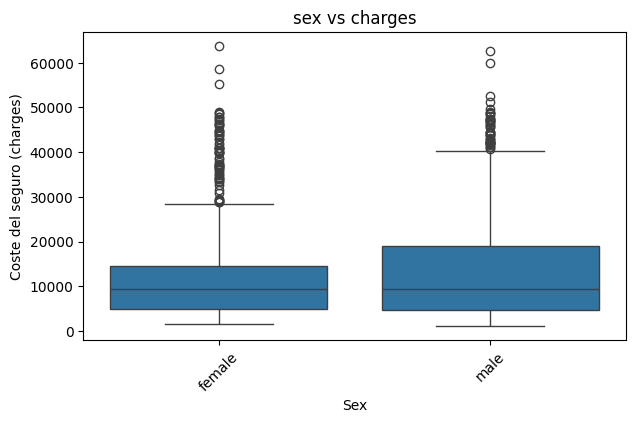

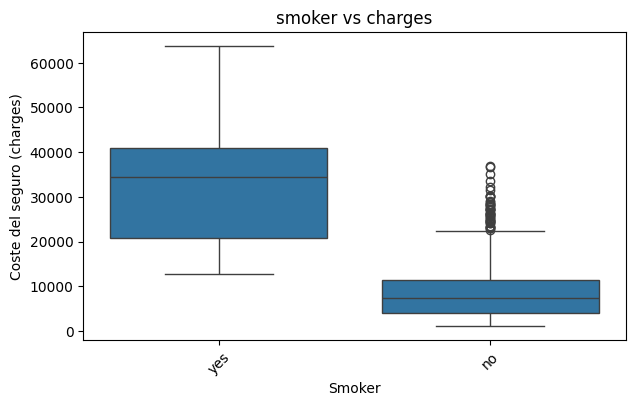

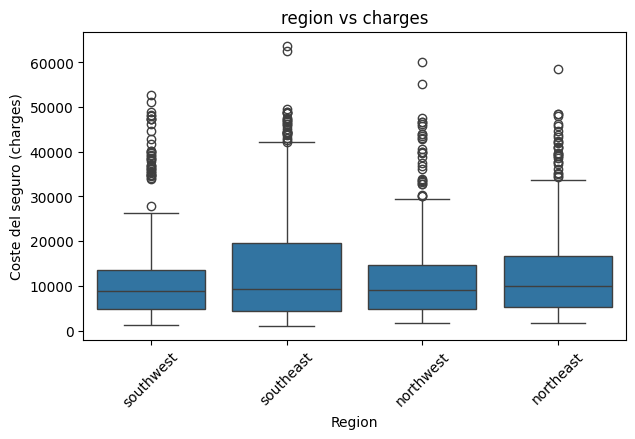

In [68]:
cat_cols = ['sex', 'smoker', 'region']

for col in cat_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=col, y='charges', data=df)
    plt.title(f"{col} vs charges")
    plt.ylabel("Coste del seguro (charges)")
    plt.xlabel(col.capitalize())
    plt.xticks(rotation=45)
    plt.show()

**sex**: Aunque sex por sí sola no tiene una fuerte correlación con charges, se conserva en el modelo ya que puede interaccionar con otras variables (como edad, smoker, etc.). Además, eliminarla podría suponer pérdida de información útil, y no aporta sobreajuste al ser binaria.  
**region**:  Aunque la variable region no tiene un impacto fuerte por sí sola, se conserva en el modelo, transformada mediante One Hot Encoding. Puede aportar valor cuando se combina con otras variables y no introduce ruido ni complejidad excesiva.  
**smoker**: es esencial para el modelo. No solo tiene una gran correlación con charges, sino que segmenta fuertemente la población en términos de coste. Se transforma en variable dummy (smoker_yes) y se incluye sin duda alguna.

In [69]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Análisis de las variables numéricas**.   
**age**:  
Distribución muy equilibrada y centrada en torno a la media.  
Sin outliers evidentes (máximo y mínimo dentro de rangos esperados).  
No requiere transformación.  
Decisión: Usarla tal cual.  

**bmi**:  
Valores por encima de ~40 podrían considerarse outliers (obesidad severa).    
Podríamos crear una variable binaria (obese).     
También se puede considerar una transformación si estás usando modelos sensibles a valores extremos.    
Valores extremos típicos de personas con problemas de salud pueden influir fuertemente en el coste del seguro.  
Decisión: Agregar una variable binaria obese = bmi > 35.  

**children**:  
Variable discreta, sin outliers (máximo 5).  
Distribución sesgada hacia 0-2 hijos.  
No necesita transformación.  
Decisión: Se deja tal cual.  

**charges**.  
Distribución fuertemente asimétrica (cola derecha).  
Valores extremos muy altos que podrían distorsionar el modelo.  
Transformación logarítmica recomendada para estabilizar varianza y mejorar el ajuste.  
Decisión: Probamos y comparmos con y sin log-transformación.  

In [70]:
df['obese'] = (df['bmi'] > 35).astype(int)

**Análisis comparativo: creación de la variable `obese`**

La variable `bmi` (Índice de Masa Corporal) es una medida numérica continua que representa la relación entre peso y altura. Aunque es útil tal como está, decidimos **crear una variable derivada llamada `obese`** con el objetivo de capturar explícitamente los casos de obesidad.

**Justificación:**

- En medicina, un **BMI superior a 35** se considera **obesidad clase II o severa**, lo que está estrechamente relacionado con mayores costes médicos.
- Observando el boxplot de `charges` versus `bmi`, notamos que a partir de ciertos valores altos (≥ 35), el coste del seguro tiende a dispararse, especialmente en fumadores.
- Codificar este umbral de forma binaria permite al modelo **capturar mejor este salto de riesgo** sin verse afectado por la varianza continua de `bmi`.

**Análisis:**
- Esta variable ayuda a **simplificar una relación no lineal** y a reforzar la interpretación: “las personas obesas tienen un riesgo económico de salud mayor”.

**Decisión:**

- Se mantiene la variable `bmi` para conservar su valor informativo continuo.
- Se incorpora también la variable `obese` para capturar efectos umbral relevantes para el coste del seguro.

Esto mejora la capacidad predictiva del modelo sin añadir complejidad significativa, y puede ser útil también para reglas de negocio futuras o segmentación de clientes.



### Resumen final de variables y decisiones de preprocesamiento

| Variable       | Tipo         | Relevancia        | Decisión           | Justificación |
|----------------|--------------|-------------------|---------------------|----------------|
| `age`          | Numérica     | Alta              | Se conserva         | Relacionada con riesgo médico y coste; sin outliers ni transformación necesaria |
| `bmi`          | Numérica     | Alta              | Se conserva         | Buen predictor de salud; algunos valores altos, pero informativos |
| `obese` (nuevo)| Binaria      | Alta              | Se crea y conserva  | Captura efecto umbral (`bmi > 35`); mejora precisión al modelar riesgos altos |
| `children`     | Numérica     | Baja–moderada     | Se conserva         | Puede influir ligeramente en coberturas familiares; sin valores anómalos |
| `sex`          | Categórica   | Baja              | Se conserva (OHE)   | No muy influyente por sí sola, pero puede interactuar con otras variables |
| `smoker`       | Categórica   | **Muy alta**      | Se conserva (OHE)   | Principal factor de impacto en `charges`; indispensable |
| `region`       | Categórica   | Baja–moderada     | Se conserva (OHE)   | Muestra algunas diferencias regionales; no distorsiona el modelo |
| `charges`      | Numérica     | Objetivo          | Se usa con y sin log | Se prueba con y sin transformación logarítmica; se elige el mejor modelo según métricas |
| `charges_log`  | Numérica     | Objetivo (log)    | Variable auxiliar   | Ayuda a reducir sesgo por outliers; se usa para entrenar modelo alternativo |

> OHE = One Hot Encoding

In [71]:
# One Hot Encoding 
df_encoded = pd.get_dummies(df, drop_first=True)

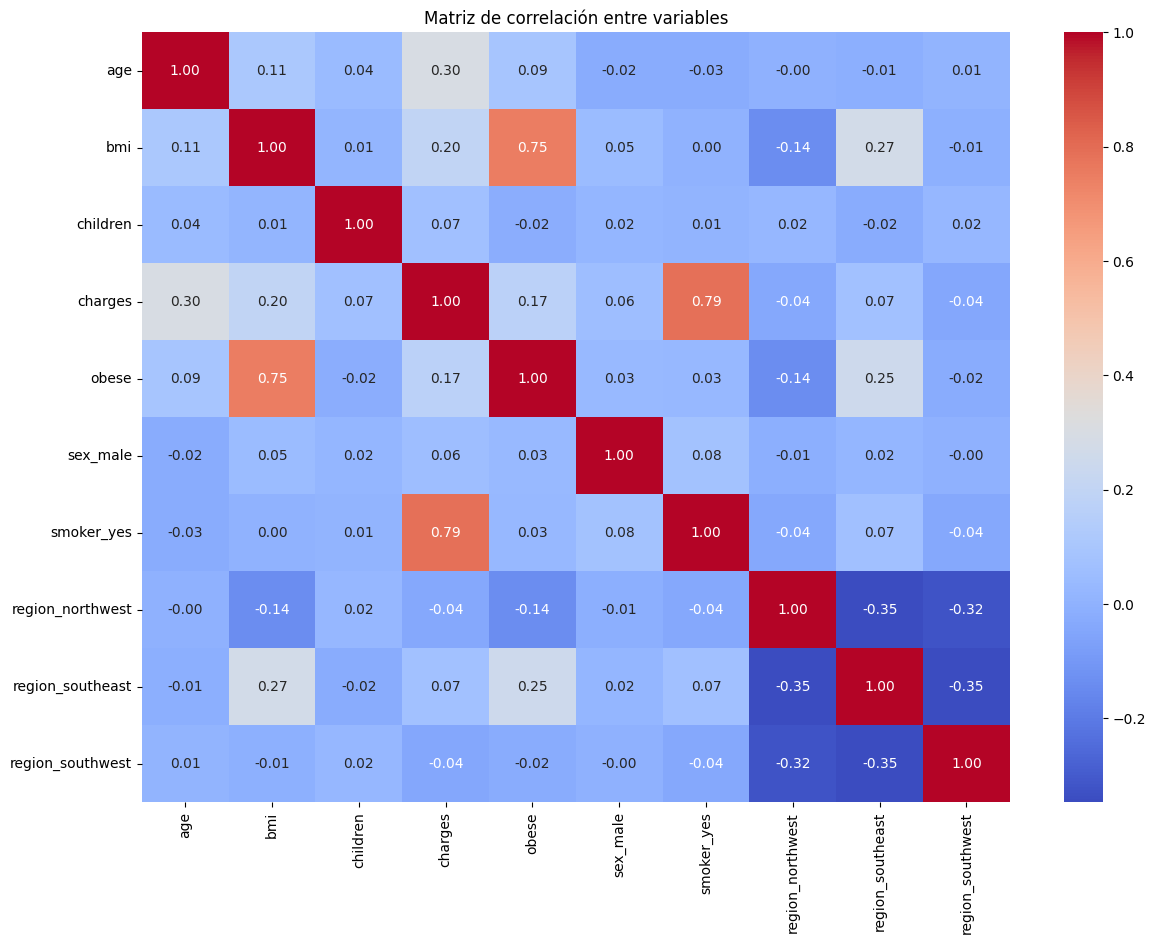

In [73]:
#Matriz de correlación entre variables
plt.figure(figsize=(14, 10))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()


***Análisis del mapa de correlación:***

A partir del heatmap de correlación entre variables numéricas y categóricas codificadas, se extraen las siguientes conclusiones:

**Variables más correlacionadas con `charges`:**
- `smoker_yes` (0.79): Fumar es el principal factor predictivo del coste del seguro.
- `age` (0.30): A mayor edad, mayor riesgo y mayor coste.
- `bmi` (0.20) y `obese` (0.17): La obesidad influye, tanto de forma continua como con umbrales.
- `children`, `sex_male` y `region_*`: Impacto bajo o muy bajo.

**Otras observaciones:**
- `bmi` y `obese` tienen una correlación alta (0.75), como es esperable. No se considera colinealidad problemática ya que ambas aportan valor complementario: una como variable continua y otra como efecto umbral.
- No se detectan otras correlaciones preocupantes entre variables predictoras.

**Decisión:**
- Se mantienen todas las variables predictoras analizadas.
- Se prioriza `smoker_yes`, `age`, `bmi`, `obese` en la interpretación del modelo por su mayor relevancia.


In [74]:
# Crear columna logarítmica para comparar modelos con y sin log
df_encoded['charges_log'] = np.log1p(df_encoded['charges'])

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
# Modelo 1: sin transformación
X1 = df_encoded.drop(['charges', 'charges_log'], axis=1)
y1 = df_encoded['charges']

In [77]:
# Modelo 2: con log(charges)
X2 = df_encoded.drop(['charges', 'charges_log'], axis=1)
y2 = df_encoded['charges_log']

In [78]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [79]:
# Crear carpeta si no existe
import os
os.makedirs("../data/processed", exist_ok=True)

# Guardar datos
train_data = X1_train.copy()
train_data["charges"] = y1_train.values
train_data.to_csv("../data/processed/clean_train.csv", index=False)

test_data = X1_test.copy()
test_data["charges"] = y1_test.values
test_data.to_csv("../data/processed/clean_test.csv", index=False)

print("Datos de entrenamiento y prueba guardados con 'charges'.")


Datos de entrenamiento y prueba guardados con 'charges'.


### Entrenar modelos:

In [80]:
# Modelo 1
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression()

In [81]:
y1_pred = model1.predict(X1_test)
y1_pred

array([ 8954.43082343,  7127.46656313, 36869.58636154,  9427.50151898,
       27066.0660126 , 10815.07566775,   108.46750435, 16770.8845771 ,
         959.8265012 , 11238.67088799, 28063.99870143,  9433.87060374,
        5330.31818435, 38367.1408234 , 40196.78145772, 36998.69375471,
       15198.8080374 , 35782.85706892,  9153.89370171, 31474.28151991,
        3788.2057271 , 10224.25652824,  2439.61779312,  7057.40600586,
       11315.14113026, 13076.71704297, 14339.62940823,  6211.47762995,
        9971.69431582,  2256.91024029,  9149.9520784 , 13160.44299041,
        4719.60652033,  3290.45260015,  4517.4197845 , 12945.62846533,
        1981.93396741,  8870.64038627, 33233.94612071, 32430.63273118,
        3928.03008388,  4400.21831076, 13979.92806227, 11404.72922725,
        8618.94369599, 12112.55432203,  5390.37917569,  3109.08031452,
       35342.45239803,  9037.76607379, 15700.38872713,  2405.56344142,
       12288.2036553 ,  1490.94738443, 13535.41682885, 12668.1076312 ,
      

In [82]:
mse1 = mean_squared_error(y1_test, y1_pred)
r2_1 = r2_score(y1_test, y1_pred)
print('mse1:',mse1)
print('r2_1:',r2_1)

mse1: 33662845.68577334
r2_1: 0.7831683044214947


In [83]:
# Modelo 2 (con log)
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression()

In [84]:
y2_pred_log = model2.predict(X2_test)
y2_pred = np.expm1(y2_pred_log)  # Convertir a escala original
y2_test_original = np.expm1(y2_test)
y2_pred

array([ 9080.42392329,  5618.56625672, 66123.91624807,  9108.71758129,
       14137.05024831,  5927.48238111,  2818.03534897, 15008.92322145,
        3766.87225842, 10530.50450414, 22830.29481903,  7504.16533456,
        4453.61222448, 49699.34296747, 59629.06210185, 44657.39402841,
       11517.39968976, 42438.41606512,  7796.58231992, 32219.34669794,
        4865.72299503,  7744.32778864,  2743.00745431,  4176.1859956 ,
       11643.65841821, 11446.89823913, 12679.07671114,  5474.01413183,
        9925.2316554 ,  2607.09576048,  8633.71483828, 11834.95209996,
        3331.53880096,  5220.18462989,  3800.97277983,  8520.77127809,
        3276.36142509,  7318.34146705, 46215.00635825, 26482.00380462,
        4566.57937393,  3609.46753436, 12246.83585154, 10736.14217536,
        5595.56304356, 11350.69549274,  4257.85278393,  4384.05285523,
       40918.95502477,  5427.27287488, 14112.8562007 ,  2827.52273736,
        8199.56975821,  2818.86874047, 10187.14406597, 11051.31417754,
      

In [85]:
mse2 = mean_squared_error(y2_test_original, y2_pred)
r2_2 = r2_score(y2_test_original, y2_pred)
print('mse2:',mse2)
print('r2_2:',r2_2)

mse2: 60901412.78862726
r2_2: 0.607717163268066


In [86]:
print("📈 Modelo 1 (sin log):")
print(f"MSE: {mse1:.2f}")
print(f"R² Score: {r2_1:.4f}")

print("\n📉 Modelo 2 (con log):")
print(f"MSE: {mse2:.2f}")
print(f"R² Score: {r2_2:.4f}")


📈 Modelo 1 (sin log):
MSE: 33662845.69
R² Score: 0.7832

📉 Modelo 2 (con log):
MSE: 60901412.79
R² Score: 0.6077



**Decisión final:**.  

Se selecciona el **Modelo 1 (sin log)** como modelo definitivo, ya que ofrece:
- Menor error cuadrático medio
- Mayor capacidad explicativa de la varianza en los datos

Además, este modelo tiene la ventaja de:
- Ser más **intuitivo y directo** en su interpretación
- Predecir `charges` en su escala real (euros), lo cual es **útil para el negocio y comunicación de resultados**

In [87]:
# Evaluación del Modelo 1 en Train vs Test

# Predicciones en train y test
y1_train_pred = model1.predict(X1_train)
y1_test_pred = model1.predict(X1_test)

# Métricas en entrenamiento
mse_train = mean_squared_error(y1_train, y1_train_pred)
r2_train = r2_score(y1_train, y1_train_pred)

# Métricas en prueba
mse1
r2_1

# Mostrar métricas comparativas
print("\n Comparación del Modelo 1 (sin log) - Train vs Test")

print("\n Entrenamiento (train):")
print(f"MSE: {mse_train:.2f}")
print(f"R² Score: {r2_train:.4f}")

print("\n Prueba (test):")
print(f"MSE: {mse1:.2f}")
print(f"R² Score: {r2_1:.4f}")



 Comparación del Modelo 1 (sin log) - Train vs Test

 Entrenamiento (train):
MSE: 37270049.09
R² Score: 0.7418

 Prueba (test):
MSE: 33662845.69
R² Score: 0.7832


**Interpretación:**
- El modelo obtiene **mejor rendimiento en el conjunto de prueba** que en el de entrenamiento, lo cual puede ocurrir cuando:
  - El conjunto de test es representativo y bien balanceado.
  - El modelo ha aprendido patrones generales sin sobreajustarse a los datos de entrenamiento.
- No hay signos de overfitting, ya que el rendimiento es **consistente o incluso ligeramente mejor en test**.
- El modelo muestra una **muy buena capacidad de generalización** y se considera **apto para su implementación o presentación como modelo final**.

**Optimización:**.  

Un modelo de Regresión Lineal no tiene hiperparámetros que optimizar. Debemos utilizar otro modelo para realizar mejoras como un modelo de regularización o modelos no lineales.